In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [56]:
df = pd.read_csv('GBPUSD_open_5year.csv')

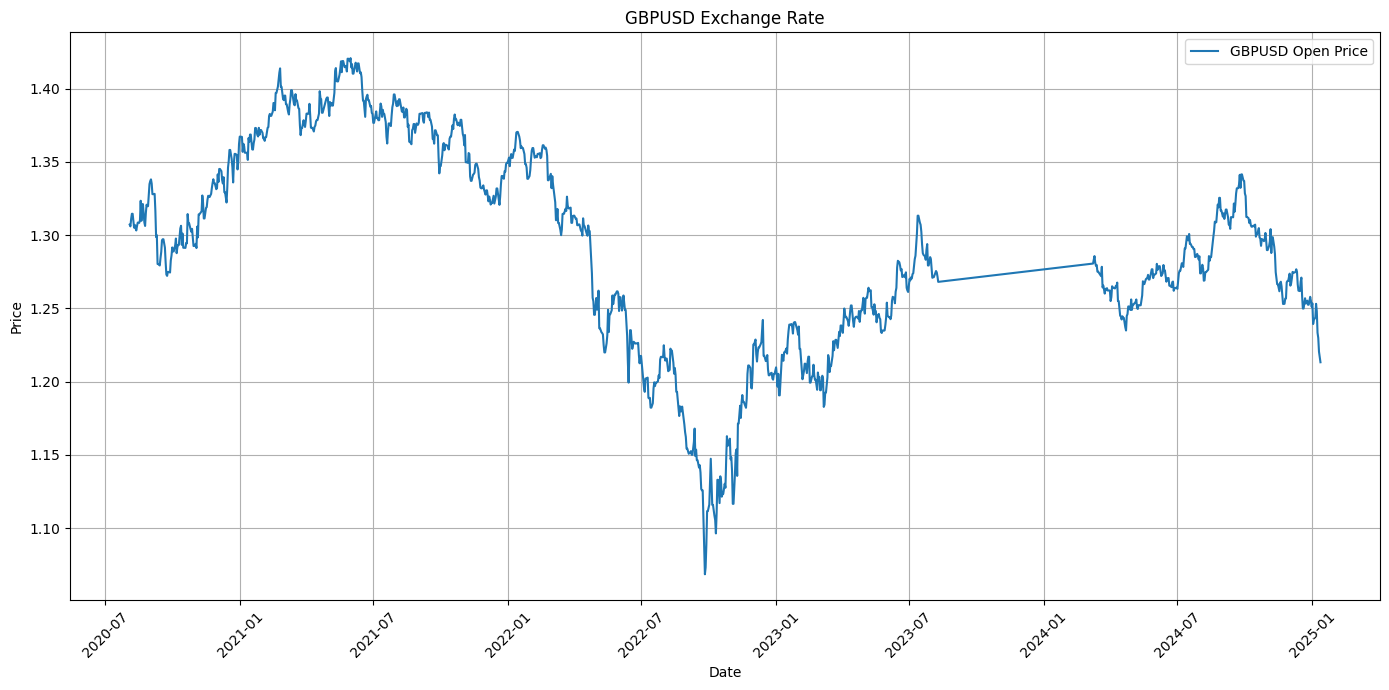

In [57]:
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.sort_values(by="Date", inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Open'], label='GBPUSD Open Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GBPUSD Exchange Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [58]:
df.set_index('Date', inplace=True)

In [59]:
# Splitting dataset
#train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
#train_size = int(len(df) * train_ratio)
#val_size = int(len(df) * val_ratio)
#test_size = len(df) - train_size - val_size

#train_data = df[:train_size]
#val_data = df[train_size:train_size + val_size]
#test_data = df[train_size + val_size:]

#print(f"Training Data: {train_data.shape}")
#print(f"Validation Data: {val_data.shape}")
#print(f"Test Data: {test_data.shape}")

In [60]:
train_data = df.iloc[:935]
remaining_data = df.iloc[935:]
validation_size = len(remaining_data) // 2

val_data = remaining_data.iloc[:validation_size]
test_data = remaining_data.iloc[validation_size:]

# Print the number of samples in each set
print(f"Training Data: {len(train_data)} samples")
print(f"Validation Data: {len(val_data)} samples")
print(f"Test Data: {len(test_data)} samples")

Training Data: 935 samples
Validation Data: 132 samples
Test Data: 133 samples


In [61]:
# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data[['Open', 'Time']])

X_train_scaled = scaler.transform(train_data[['Open', 'Time']])
X_val_scaled = scaler.transform(val_data[['Open', 'Time']])
X_test_scaled = scaler.transform(test_data[['Open', 'Time']])

y_train = train_data['Open'].values
y_val = val_data['Open'].values
y_test = test_data['Open'].values

In [62]:
def time_sequence_generator(X, y, time_interval):
    X_range, y_range = [], []
    for i in range(len(X) - time_interval):
        X_range.append(X[i:i+time_interval])
        y_range.append(y[i+time_interval])
    return np.array(X_range), np.array(y_range)

In [63]:
time_interval= 60

X_train_seq, y_train_seq = time_sequence_generator(X_train_scaled, y_train, time_interval)
X_val_seq, y_val_seq = time_sequence_generator(X_val_scaled, y_val, time_interval)
X_test_seq, y_test_seq = time_sequence_generator(X_test_scaled, y_test, time_interval)

print(f"Shape of X_train: {X_train_seq.shape}")
print(f"Shape of X_val: {X_val_seq.shape}")
print(f"Shape of X_test: {X_test_seq.shape}")

Shape of X_train: (875, 60, 2)
Shape of X_val: (72, 60, 2)
Shape of X_test: (73, 60, 2)


In [64]:
# Build RNN model
rnn_model = Sequential()


rnn_model.add(SimpleRNN(units=64, activation='relu', return_sequences=True, input_shape=(time_interval, 2)))
rnn_model.add(Dropout(0.4))
rnn_model.add(SimpleRNN(units=32, activation='relu', return_sequences=True))
rnn_model.add(Dropout(0.4))
rnn_model.add(SimpleRNN(units=16, activation='relu'))
rnn_model.add(Dropout(0.4))

rnn_model.add(Dense(units=8, activation='relu'))
#output
rnn_model.add(Dense(units=1))

rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

history = rnn_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_data=(X_val_seq, y_val_seq))

Epoch 1/200


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1.2077 - mae: 0.9784 - mse: 1.2077 - val_loss: 0.1801 - val_mae: 0.4242 - val_mse: 0.1801
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4680 - mae: 0.5868 - mse: 0.4680 - val_loss: 0.0036 - val_mae: 0.0584 - val_mse: 0.0036
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2623 - mae: 0.4231 - mse: 0.2623 - val_loss: 0.0070 - val_mae: 0.0830 - val_mse: 0.0070
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1930 - mae: 0.3540 - mse: 0.1930 - val_loss: 0.0125 - val_mae: 0.1116 - val_mse: 0.0125
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1665 - mae: 0.3163 - mse: 0.1665 - val_loss: 0.0045 - val_mae: 0.0669 - val_mse: 0.0045
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1354 - mae: 0.2964 - mse: 0.1354 - val_loss: 0.0313 - val_mae: 0.1768 - val_mse: 0.0313
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1260 - mae: 0.2869 - mse: 0.1260 - val_loss: 0.030

In [65]:
# Evaluate
test_loss = rnn_model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss (RNN): {test_loss}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.4048e-04 - mae: 0.0170 - mse: 4.4048e-04
Test Loss (RNN): [0.00042850166209973395, 0.016481850296258926, 0.00042850166209973395]


In [66]:
# Predictions
y_pred = rnn_model.predict(X_test_seq)

y_pred = scaler.inverse_transform(np.column_stack((y_pred, np.zeros(y_pred.shape))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test_seq.reshape(-1, 1), np.zeros(y_test_seq.shape))))[:, 0]

mae_rnn = mean_absolute_error(y_test_actual, y_pred)
mse_rnn = mean_squared_error(y_test_actual, y_pred)
r2_rnn = r2_score(y_test_actual, y_pred)
mape_rnn = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


In [67]:
print(f"RNN Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_rnn:.4f}")
print(f"Mean Squared Error (MSE): {mse_rnn:.4f}")
print(f"R² Score: {r2_rnn:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_rnn:.2f}%")

RNN Model Performance on Test Data:
Mean Absolute Error (MAE): 0.0058
Mean Squared Error (MSE): 0.0001
R² Score: 0.0051
Mean Absolute Percentage Error (MAPE): 0.38%


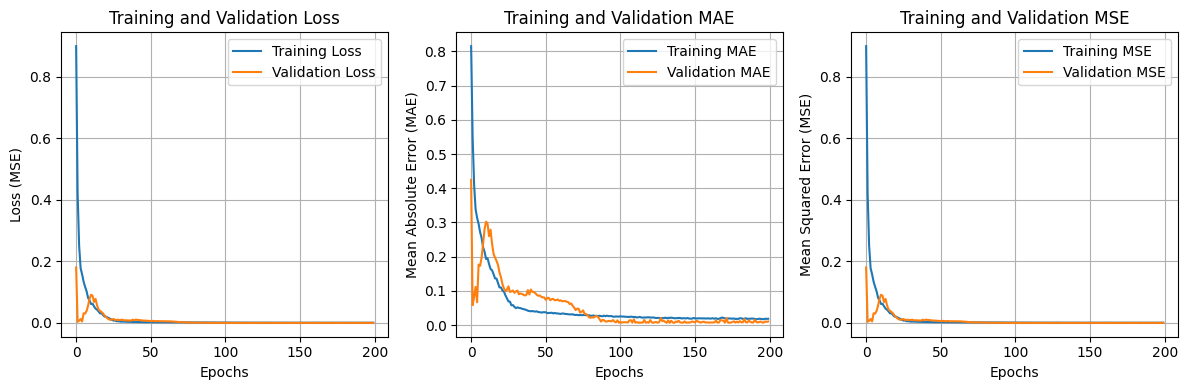

In [68]:
# Plot Training History
history_dict = history.history

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 3, 2)
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

# MSE
plt.subplot(1, 3, 3)
plt.plot(history_dict['mse'], label='Training MSE')
plt.plot(history_dict['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()